In [125]:
import json
import os
from pprint import pprint
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm, remove_weight_norm
import torch.nn.functional as F
import scipy
from scipy.io import wavfile, loadmat, savemat
import sklearn
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, root_mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import librosa
from itertools import combinations
from collections import Counter

plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
LRELU_SLOPE = 0.1
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [3]:
low, srl = librosa.load("low.m4a")
high, srh = librosa.load("high.m4a")
low

/var/folders/0f/x7xs6kjs6k7dfph84ymzzlrr0000gn/T/ipykernel_69560/3975378833.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  low, srl = librosa.load("low.m4a")
/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/0f/x7xs6kjs6k7dfph84ymzzlrr0000gn/T/ipykernel_69560/3975378833.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  high, srh = librosa.load("high.m4a")
/opt/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


array([-0.00074496, -0.00117482, -0.00105143, ...,  0.00134376,
        0.00135215,  0.00133266], dtype=float32)

In [4]:
filter_banks = librosa.filters.mel(n_fft=2048, sr=22050, n_mels=3)

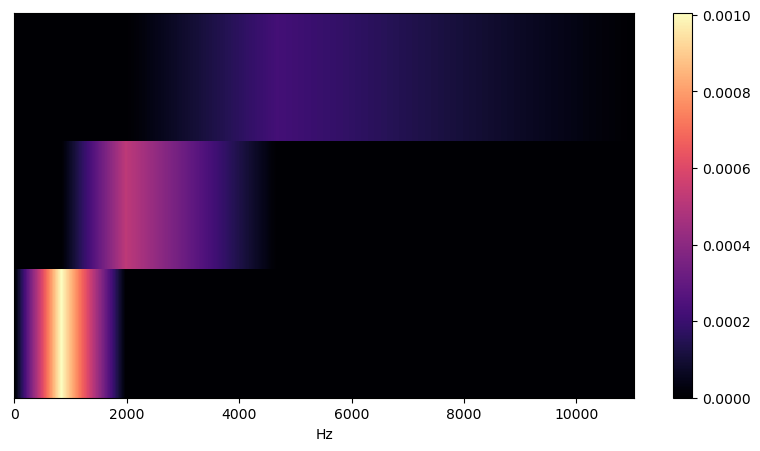

In [5]:
librosa.display.specshow(filter_banks, sr=22050, x_axis='linear')
plt.colorbar()
plt.show()

In [6]:
mel_low = librosa.feature.melspectrogram(y=low, sr=22050, n_fft=2048, hop_length=512, n_mels=100)
log_low = librosa.power_to_db(mel_low)
mel_high = librosa.feature.melspectrogram(y=high, sr=22050, n_fft=2048, hop_length=512, n_mels=100)
log_high = librosa.power_to_db(mel_high)

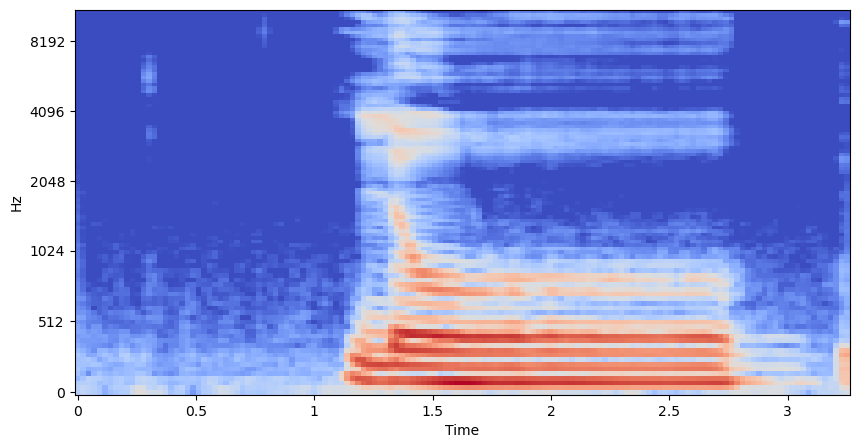

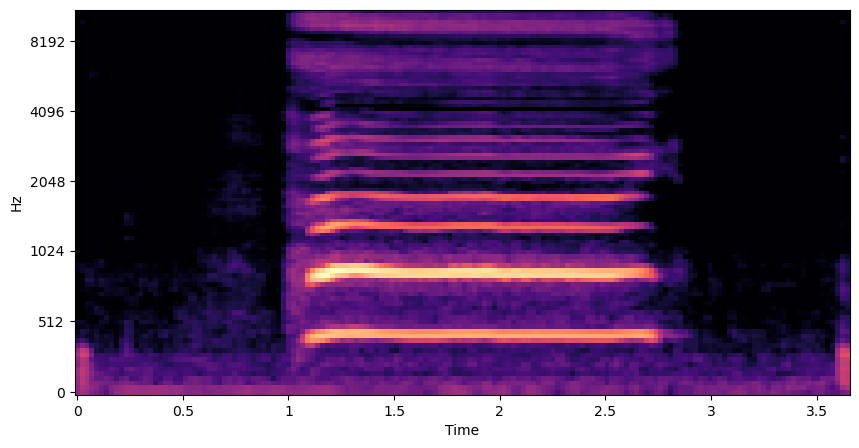

In [7]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
librosa.display.specshow(log_low, x_axis="time", y_axis="mel", sr=22050, ax=ax1)
librosa.display.specshow(log_high, x_axis="time", y_axis="mel", sr=22050, ax=ax2)

In [8]:
def audio_to_spectrogram(audiofiles, n_fft, n_mels, hop_length, sr=22050):
    if isinstance(audiofiles, str):
        audiofiles = [audiofiles]
    for audiofile in audiofiles:
        try:
            audio, sr = librosa.load(audiofile, sr=sr)
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            return mel
        except e:
            print(f"Error generating spectgram for {audiofile}: {e}")

In [9]:
# Input will be EEG signals with IN_CH electrodes
# Output will be mel spectrogram with OUT_CH mel bands
IN_CH = 4
OUT_CH = 100

class Generator(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(Generator, self).__init__()
        
        # Upsample data to some high nuumber of channels to have many possible features
        self.conv_pre = nn.Conv1d(IN_CH, channels, kernel_size=3)
        
        # Downsample data incrementally to combine features and form the mel spectrogram
        # This is called upsampling because ConvTranspose has an upsamplig property
        self.ups = nn.ModuleList()
        for i in range(3):
            self.ups.append(
                nn.ConvTranspose1d(in_channels=channels, out_channels=channels//2,
                                                 kernel_size=kernel_size, stride=1)
            )
            channels //= 2

        # Downsample data to the desired number of mel bands
        self.conv_post = nn.Conv1d(channels, OUT_CH, kernel_size=9)

    def forward(x):
        x = self.conv_pre(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        for up in self.ups:
            x = up(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
        x = self.conv_post(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        x = torch.tanh(x)
        return x
            

    
    

In [10]:

class Discriminator(nn.Module):
    def __init__(self, channels, kernel_size=3):
        super(Discriminator, self).__init__()

        self.num_downs = 3
        
        # Upsample from input channels to a large number of channels
        self.conv_pre = nn.Conv1d(IN_CH, channels, kernel_size=3)
        
        # Upsample data incrementally to extract relevant features
        # This is referred to as downsample because we use Conv layer which has a downsampling property 
        self.downs = nn.ModuleList()
        for i in range(self.num_downs):
            self.downs.append(
                nn.Conv1d(in_channels=channels, out_channels=channels*2,
                                                 kernel_size=kernel_size, stride=1)
            )
            channels *= 2

        # Downsample data to the desired number of channels to compare generator spectrogram with 
        # actual spectrogram
        self.conv_post = nn.Conv1d(channels, OUT_CH, kernel_size=9)

        # FC Layer to get probability that the data is actual
        self.adv = nn.Sequential(nn.Linear(channels, 1), nn.Sigmoid())

    def forward(x):
        x = self.conv_pre(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        for down in self.downs:
            x = down(x)
            x = F.leaky_relu(x, LRELU_SLOPE)
        x = self.conv_post(x)
        x = F.leaky_relu(x, LRELU_SLOPE)
        validity = self.adv(x)
        return validity

In [11]:

# stepping up number of channels in generater and discriminator to INIT_UP and INIT_DOWN number of channels
INIT_UP = 1024
INIT_DOWN = 64

def train(num_epochs, dataLoader):
    # For loop which runs for num_epochs

    # Get current batch of data

    # train_G and train_D

    pass

def train_G(X, y):

    # Zero grad
    
    # Forward pass of geenrator

    # Calculate Loss with different criteria for generator

    # Step gradient

    pass

def train_D(X, y):

    # Zero grad
    
    # Forward pass of geenrator

    # Calculate Loss with different criteria for generator

    # Step gradient

    pass
    

In [12]:
X = torch.tensor([[
    [1, 2, 3, 11, 12, 13],
    [4, 5, 6, 14, 15, 16],
    [7, 8, 9, 17, 18, 19]
]], dtype=torch.float32)
m = nn.ConvTranspose1d(3,1, 5, 3, padding=10, dilation=4)
m.apply(lambda model: model.weight.data.fill_(1.0))
m.apply(lambda model: model.bias.data.zero_())
print(X.shape)
print(m.weight.shape)
print(m(X).shape)

torch.Size([1, 3, 6])
torch.Size([3, 1, 5])
torch.Size([1, 1, 12])


In [134]:
def rmse(y_pred, y_target):
    y_pred = np.array(y_pred)
    y_target = np.array(y_target)
    return np.sqrt(np.mean(np.power(y_pred - y_target, 2), axis=0))


"""
Computes the distance of average of each feature over all classes and selects some of the features which ve the highest distance between the classes
@param X: np.ndarray of shape (num_samples, num_features+1). The last of the features is taken to the label of the class, labels is left as default
@param U: int. number of features to select from the final distances of all the features
@param labels: int. The index along axis=1 which represents the labels of the classes
@return: np.ndarray of length U. Set of the features with the largest average distance, sorted in descending order of distance
"""
def aden(X, U, labels = -1):
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if labels == -1:
        labels = X.columns[-1]
    x_avg = X.groupby(labels).mean()
    combs = combinations(range(len(x_avg)), 2)
    
    classlist1, classlist2 = [], []
    for c1, c2 in combs:
        classlist1.append(np.array(x_avg.iloc[c1]))
        classlist2.append(np.array(x_avg.iloc[c2]))
    
    feature_deviations = rmse(np.array(classlist1), np.array(classlist2))
    pprint(Counter((feature_deviations.argsort()[::-1][:125] // 35) % 16))
    return feature_deviations.argsort()[-U:][::-1]
    

In [14]:
#x = np.array([[1, 3, 5, 1], [5, 3, 3, 1], [5, 2, 3, 0],
#             [3, 4, 5, 2], [0, 2, 8, 0], [1, 4, 8, 2]])

#aden(x, 1)

In [135]:
sample_data = pd.read_csv("TestData/GTP000_Data.csv")
sample_data = sample_data.drop("Unnamed: 0", axis=1)
#print(sample_data.iloc[0, :35])
sample_labels = pd.read_csv("TestData/GTP000_Labels.csv", header=None)[0].to_numpy()
sample_data["labels"] = sample_labels
sample_data_np = sample_data.to_numpy()
top_features = aden(sample_data_np, 6)
sample_features = sample_data_np[:, top_features]


Counter({4: 23, 8: 22, 9: 15, 10: 15, 5: 13, 3: 10, 2: 9, 0: 8, 1: 8, 11: 2})


In [96]:
X_train, X_test, y_train, y_test = train_test_split(sample_features, sample_labels, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#f1 = f1_score(y_test, y_pred)
#roc_auc = roc_auc_score(y_test, y_pred)

In [97]:
accuracy

0.030303030303030304